In [1]:
from warnings import filterwarnings

filterwarnings("ignore")

import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import qmc
import random 
import time
from sklearn.metrics import mean_squared_error, r2_score

from scipy.integrate import quad

In [2]:
seed = 31

MSE = {}
RMSE = {}
MAE = {}
R2 = {}
Time = {}

MSE_var = {}
RMSE_var = {}
MAE_var = {}
R2_var = {}
Time_var = {}

ms = []

inference_time = {}
mse = {}
r2 = {}

In [3]:
from random import randint
def generate_fourier_random_function(domain_min, domain_max):
    """Generate random function using Fourier series and normalize"""
    n_terms = np.random.randint(6,10)
    L = domain_max - domain_min
    
    a0 = np.random.randn()
    a_coeffs = np.random.randn(n_terms)
    b_coeffs = np.random.randn(n_terms)
    
    def raw_function(x):
        result = a0/2
        for n in range(1, n_terms+1):
            result += np.array(a_coeffs[n-1]) * np.cos(2*n*np.pi*x/L)
            result += np.array(b_coeffs[n-1]) * np.sin(2*n*np.pi*x/L)
        return result
    
    def positive_function(x):
        return np.log(1 + np.exp(raw_function(x)))
    
    integral, _ = quad(positive_function, domain_min, domain_max)
    
    def normalized_function(x):
        res = []
        for i in x:
            res.append(positive_function(i) / integral)
        # if len(res)==1:
        #     return res[0]
        # else:
        return np.array(res)
    
    return normalized_function

In [4]:
test_size = 10

functions = []

for _ in range(test_size):
    functions.append(generate_fourier_random_function(-1, 1))

In [5]:
l_bounds = [-1.]
u_bounds = [1.]
bounds = [[-1.,1.]]
n_i = 10
train_points = np.linspace(-1, 1, n_i).reshape(-1, 1)

sampler = qmc.LatinHypercube(d=1)
sample = sampler.random(n=1000)
sample_scaled = qmc.scale(sample, -1, 1)
test_points = np.array(sample_scaled).reshape(-1, 1)

n_add = 30

# GP

In [7]:
from gale.doe import SeqED, adaptive_sampling

In [13]:
for as_name in ['GUESS','wMMSE','MMSE','TEAD']:#,'wMMSE','MMSE','TEAD'
    MSE_ = []
    MAE_ = []
    R2_ = []
    Time_ = []
    Time_inf = []

    for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)
        
        n_c = n_i+n_add
        ncalls = n_i+n_add

        method = adaptive_sampling[as_name](bounds=bounds,\
                                                n_init=n_i, rnd_state=seed, model="GP",optimizer ="diff_evo",n_max = n_c,init_sampling = train_points,init_sampling_y = train_answers)

        doe = SeqED(fun=f, adaptive_method=method, n_calls=ncalls,verbose=0, eval_performance=1,bench_sampling = test_points,freq=1,\
                                                x=train_points,y=train_answers,y_true=test_answers)
        res = doe.run()
        
        MSE_.append(res['metrics'][0]['results'])
        MAE_.append(res['metrics'][1]['results'])
        R2_.append(res['metrics'][2]['results'])
        Time_.append(np.array(res['ask_time'][n_i:])+np.array(res['tell_time'][n_i:]))
        ms.append(res['model'])

    MSE[as_name] = np.mean(MSE_,axis=0)[1:]
    MSE_var[as_name] = np.var(MSE_,axis=0)[1:]

    RMSE[as_name] = np.mean(np.sqrt(MSE_),axis=0)[1:]
    RMSE_var[as_name] = np.var(np.sqrt(MSE_),axis=0)[1:]
    
    MAE[as_name] = np.mean(MAE_,axis=0)[1:]
    MAE_var[as_name] = np.var(MAE_,axis=0)[1:]
    
    R2[as_name] = np.mean(R2_,axis=0)[1:]
    R2_var[as_name] = np.var(R2_,axis=0)[1:]
    
    Time[as_name] = np.mean(Time_,axis=0)
    Time_var[as_name] = np.var(Time_,axis=0)

# Neural Network

In [16]:
from importlib import reload 
import QBC
QBC = reload(QBC)
from QBC import run_NN_sampling

In [17]:
MSE_ = []
MSE_aggr = []
R2_ = []
R2_aggr = []
Time_ = []


for f in functions:
       train_answers = f(train_points)
       test_answers = f(test_points)

       qbc_model,qbc_models,mse_a,r2_a,qbc_mse,qbc_r2,qbc_t = run_NN_sampling(f,l_bounds,u_bounds,\
                                                                           train_points,train_answers,test_points,\
                                                                           test_answers,INPUT_SIZE=1,n_splits = 3,\
                                                                           nb_points_added=n_add,freq=1) 
        
       MSE_.append(qbc_mse)
       MSE_aggr.append(mse_a)
        
       R2_.append(qbc_r2)
       R2_aggr.append(r2_a)
       Time_.append(qbc_t)

In [18]:
MSE['QBD'] = np.mean(MSE_,axis=0)
R2['QBD'] = np.mean(R2_,axis=0)
R2_var['QBD'] = np.var(R2_,axis=0)

Time['QBD'] = np.mean(Time_,axis=0)

# MSE['QBD_agg'] = np.mean(MSE_,axis=0)
# R2['QBD_agg'] = np.mean(R2_,axis=0)
# Time['QBD_agg'] = np.mean(Time_,axis=0)

# CAS4DL

In [20]:
from DNN_sampling import run

In [21]:
MSE_ = []
MAE_ = []
R2_ = []
Time_ = []
Time_inf = []

In [22]:
for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)

        as_model,cas_mse,_,cas_r2,cas_t = run(l_bounds, u_bounds, 32, f ,train_points, train_answers.reshape(-1,1), test_points.reshape(-1,1), test_answers, 'ASGD')
        
        MSE_.append(cas_mse)
        R2_.append(cas_r2)
        Time_.append(cas_t)

batching with 16 out of 1000 uniform_random training points
initializing (W,b) with N(0, 0.1^2)
Using single precision
Training points shape: (1000, 1)
Testing points shape:(1000, 1)
y_train data shape: (1000, 1)
y_test data shape:(1000, 1)
Input dim: 1  | Grid size:  1000  | Correct grid size for dimension
k init value:  6.0 k final value:  31.0
N_max: 16
k values: [1 2]
M values: [ 50 100]
based on init rate = 0.001, decay_steps = 1000.0, calculated base = 0.46762422391131064, so that after 10000 epochs we have final learning rate = 4.999999999999998e-07
adding layer dense_u0
adding layer dense_u1
adding layer dense_u2
adding layer dense_u3
adding layer second_to_last_u
MSE  0.15468962
-----------------------------------------------------------------------
Trial number: 0
-----------------------------------------------------------------------
----  Iteration: 0
r value:  13
rank is less to N:  13
k_max_ratio:  3 k_min_ratio:  1
size mu: (1000, 13) | Number of points: 1000
size I new:

LinAlgError: SVD did not converge

In [33]:
MSE['CAS4DL'] = np.mean(MSE_,axis=0)
R2['CAS4DL'] = np.mean(R2_,axis=0)
R2_var['CAS4DL'] = np.var(R2_,axis=0)
Time['CAS4DL'] = np.mean(Time_,axis=0)

# RL

In [36]:
from environment import Environment
from ddpg_fol.ddpg import DDPG
from sklearn.gaussian_process.kernels import Matern, ConstantKernel

In [38]:
train_points = np.concatenate((train_points,[[0]]*10))

In [40]:
class Arg:
    def __init__(self,):
        self.mode = 'test'
        self.hidden1 = 16
        self.hidden2 = 16
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=30
        self.validate_steps=500
        self.output='output_GP'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=4000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = 20
nb_actions = 1


agent = DDPG(nb_states, nb_actions, args)
agent.load_weights('../output_GP')

In [42]:
MSE_1 = []
MAE_1 = []
R2_1 = []
Time_1 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)

        env = Environment(X = train_points,y = train_answers,l_bounds = [-1],u_bounds = [1],func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='last_points',N_state=20)
        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_1.append(m)
        R2_1.append(r)
        Time_1.append(t)

MSE['RLGP_points'] = np.mean(MSE_1,axis=0)
R2['RLGP_points'] = np.mean(R2_1,axis=0)
R2_var['RLGP_points'] = np.var(R2_1,axis=0)
Time['RLGP_points'] = np.mean(Time_1,axis=0)

In [43]:
MSE_2 = []
MAE_2 = []
R2_2 = []
Time_2 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)
        env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='last_points',N_state=20)


        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_2.append(m)
        R2_2.append(r)
        Time_2.append(t)

MSE['RLNN_points'] = np.mean(MSE_2,axis=0)
R2['RLNN_points'] = np.mean(R2_2,axis=0)
R2_var['RLNN_points'] = np.var(R2_2,axis=0)
Time['RLNN_points'] = np.mean(Time_2,axis=0)

In [44]:
class Arg:
    def __init__(self,):
        self.mode = 'train'
        self.hidden1 = 32
        self.hidden2 = 32
        self.rate =0.0007
        self.prate =0.0007
        self.warmup =200
        self.discount=0.9
        self.bsize=64
        self.rmsize=100000
        self.window_length=1
        self.tau = 0.1
        self.validate_episodes=5
        self.max_episode_length=60
        self.validate_steps=500
        self.output='output_GP+'
        self.debug='debug'
        self.init_w=0.003
        self.train_iter=4000
        self.epsilon=10000
        self.seed = 1
        self.resume = 'default'
        
args = Arg()

np.random.seed(args.seed)

nb_states = 40
nb_actions = 1


agent = DDPG(nb_states, nb_actions, args)
agent.load_weights('../output_GP+')

In [45]:
MSE_3 = []
MAE_3 = []
R2_3 = []
Time_3 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)

        env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                          func = f,tes=False, model = 'GP',model_param = {'d':1,'seed':1,'kernel':ConstantKernel(1.0) * Matern([1],nu=1.5),'n_restarts_optimizer':100},state_mode='predictions+last_points')
        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_3.append(m)
        R2_3.append(r)
        Time_3.append(t)

MSE['RLGP_points+predictions'] = np.mean(MSE_3,axis=0)
R2['RLGP_points+predictions'] = np.mean(R2_3,axis=0)
R2_var['RLGP_points+predictions'] = np.var(R2_3,axis=0)
Time['RLGP_points+predictions'] = np.mean(Time_3,axis=0)

In [46]:
MSE_4 = []
MAE_4 = []
R2_4 = []
Time_4 = []

for f in functions:
        train_answers = f(train_points)
        test_answers = f(test_points)
        env = Environment(X = train_points,y = train_answers,l_bounds = l_bounds,u_bounds = u_bounds,\
                      func = f,tes=False, model = 'NN',model_param = {'d':1,'nb_nodes':16,'nb_layers':3,'verbose':False,'seed':1,'n_epoches':400},state_mode='predictions+last_points')


        state = env.reset()
        agent.is_training = False

        m = []
        r = []
        t = []
        for i in range(n_add):
            start = time.time()
            action = agent.select_action(state)
            state, reward, done, info = env.step(action)
            model = env.mod()
            m.append(mean_squared_error(model.predict(test_points),test_answers))
            r.append(r2_score(test_answers,model.predict(test_points)))
            stop = time.time()    
            t.append(stop-start)


        MSE_4.append(m)
        R2_4.append(r)
        Time_4.append(t)

MSE['RLNN_points+predictions'] = np.mean(MSE_4,axis=0)
R2['RLNN_points+predictions'] = np.mean(R2_4,axis=0)
R2_var['RLNN_points+predictions'] = np.var(R2_4,axis=0)
Time['RLNN_points+predictions'] = np.mean(Time_4,axis=0)

# Plots

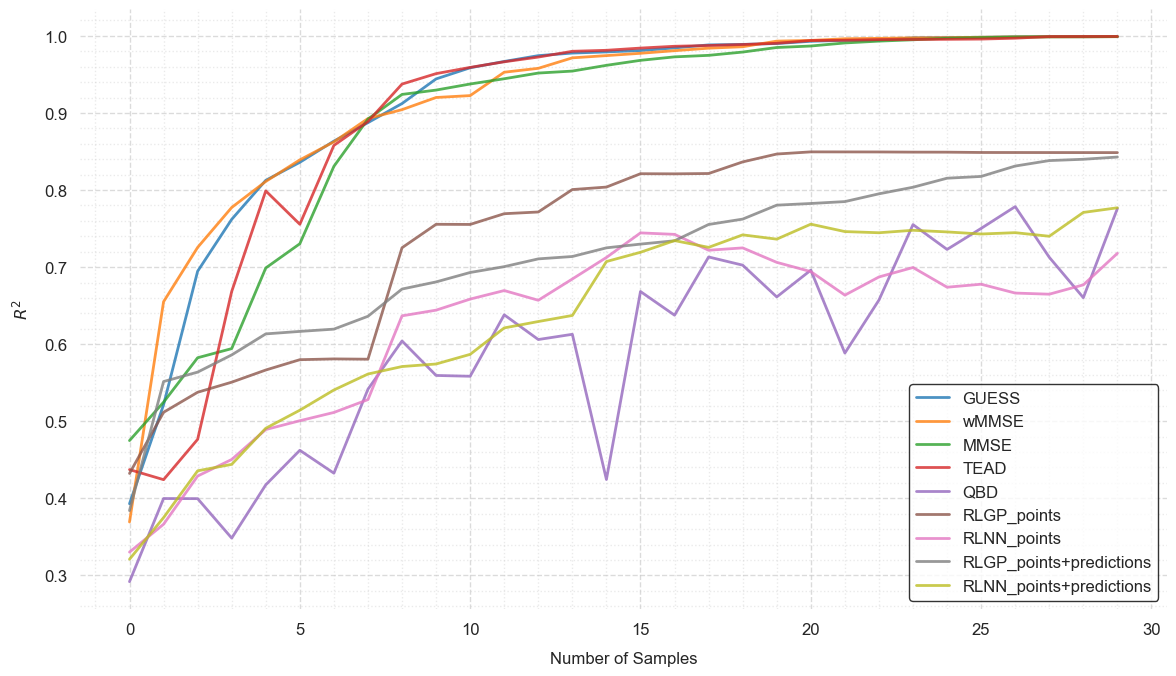

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))
methods =list(MSE.keys())

for i, method in enumerate(['GUESS','wMMSE','MMSE','TEAD','QBD','RLGP_points','RLNN_points','RLGP_points+predictions','RLNN_points+predictions']):
    ax.plot( R2[method], 
            label=method, 
            linewidth=2.,
            alpha=0.8)
    #ax.errorbar(np.arange(30),R2[method], yerr=np.sqrt(R2_var[method]))
    # ax.fill_between(
    #     np.arange(30),
    #     R2[method] - np.sqrt(R2_var[method]),
    #     R2[method] + np.sqrt(R2_var[method]),
    #     alpha=0.3,
    #     label="std dev",
    # )
#'RLNN_points',,'RLNN_points+predictions'
#ax.set_title('Performance Comparison of Adaptive Sampling Methods', 
#             pad=20, fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Samples', labelpad=10, fontsize=12)
#ax.set_yscale('log')
ax.set_ylabel('$R^2$', labelpad=10, fontsize=12)
legend = ax.legend(loc='lower right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
plt.tight_layout()
# plt.savefig('method_comparison_all.png', dpi=300, bbox_inches='tight')


plt.show()

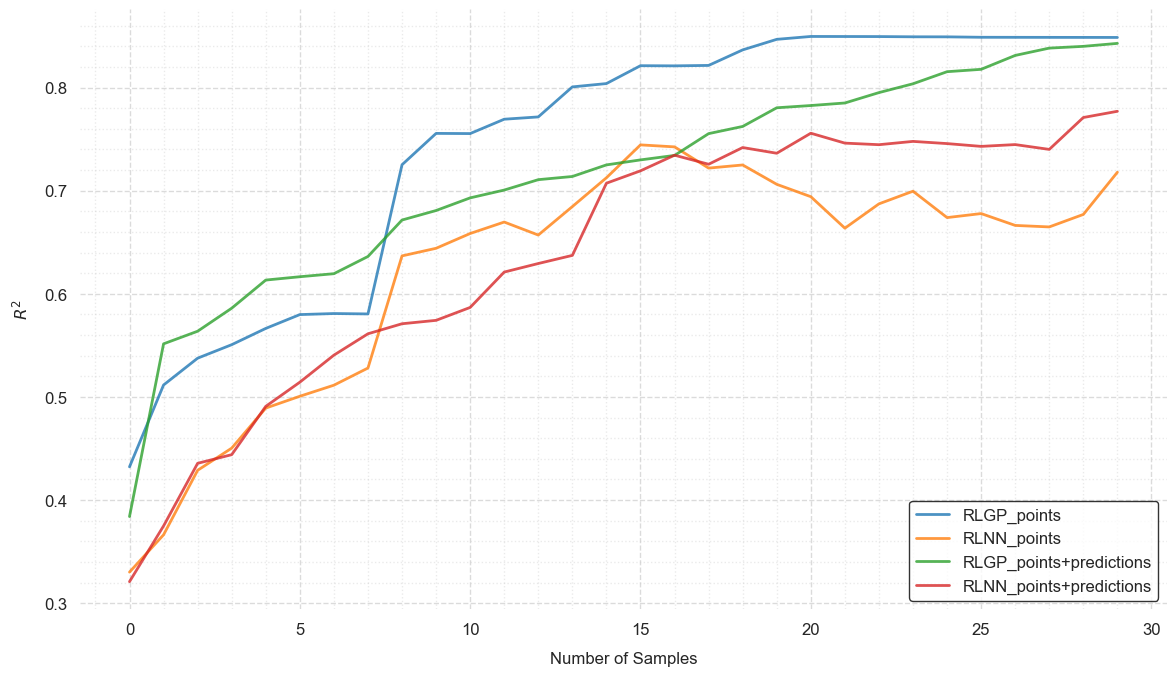

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))
methods =list(MSE.keys())

for i, method in enumerate(['RLGP_points','RLNN_points','RLGP_points+predictions','RLNN_points+predictions']):
    ax.plot(R2[method], 
            label=method, 
            linewidth=2.,
            alpha=0.8)
    #ax.errorbar(np.arange(30),R2[method], yerr=np.sqrt(R2_var[method]))
    # ax.fill_between(
    #     np.arange(30),
    #     R2[method] - np.sqrt(R2_var[method]),
    #     R2[method] + np.sqrt(R2_var[method]),
    #     alpha=0.4,
    #     label="std dev",
    # )
#'RLNN_points',,'RLNN_points+predictions'
#ax.set_title('Performance Comparison of Adaptive Sampling Methods', 
#             pad=20, fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Samples', labelpad=10, fontsize=12)
#ax.set_yscale('log')
ax.set_ylabel('$R^2$', labelpad=10, fontsize=12)
legend = ax.legend(loc='lower right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
plt.tight_layout()
plt.savefig('method_comparison_all.png', dpi=300, bbox_inches='tight')


plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))
methods =list(MSE.keys())

for i, method in enumerate(['GUESS','wMMSE','MMSE','TEAD','QBD','RLGP_points','RLNN_points','RLGP_points+predictions','RLNN_points+predictions']):
    ax.plot(R2[method], 
            label=method, 
            linewidth=2.,
            alpha=0.8)
#'RLNN_points',,'RLNN_points+predictions'
#ax.set_title('Performance Comparison of Adaptive Sampling Methods', 
#             pad=20, fontsize=16, fontweight='bold')
ax.set_xlabel('Number of Samples', labelpad=10, fontsize=12)
#ax.set_yscale('log')
ax.set_ylabel('$R^2$', labelpad=10, fontsize=12)
legend = ax.legend(loc='lower right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
plt.tight_layout()
plt.savefig('method_comparison_gp.png', dpi=300, bbox_inches='tight')


plt.show()

In [54]:
def visualize_test_sets(test_sets):
    plt.figure(figsize=(15, 10))
    
    for i, (name, data) in enumerate(test_sets.items()):
        plt.subplot(3, 2, i+1)
        plt.plot(data['x'], data['y'], label=name)
        plt.scatter(data['optimal_x_norm'], 
                   data['y'][np.argmin(np.abs(data['x'] - data['optimal_x_norm']))],
                   color='red', label='Optimum')
        plt.title(f"{name} Function (n={len(data['x'])})")
        plt.xlabel("Normalized x ∈ [-1, 1]")
        plt.ylabel("f(x)")
        plt.legend()
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


visualize_test_sets(test_sets)

['GUESS', 'wMMSE', 'MMSE', 'TEAD', 'QBD', 'QBD_agg', 'CAS4DL']

In [56]:
Time['CAS4DL']

array([1.2768321 , 1.27456689, 1.28468418, 1.34631991, 1.36504698,
       1.36800504, 1.37447214, 1.37431097, 1.38884592, 1.38934302])

In [72]:
R2

{'GUESS': array([0.80974981, 0.89259537, 0.90751064, 0.92330391, 0.92840515,
        0.94420425, 0.9452603 , 0.94658182, 0.95703926, 0.95854103,
        0.9622589 ]),
 'wMMSE': array([0.80974981, 0.89248235, 0.90741068, 0.92343608, 0.9394355 ,
        0.94162947, 0.94441077, 0.94588212, 0.95642217, 0.95659457,
        0.95764916]),
 'MMSE': array([0.81336879, 0.89405632, 0.89671292, 0.89904146, 0.89928341,
        0.90471591, 0.90630454, 0.90630723, 0.90661683, 0.92735761,
        0.93730127]),
 'TEAD': array([0.80974981, 0.9093342 , 0.923213  , 0.93990225, 0.94250526,
        0.95379905, 0.95464174, 0.95603588, 0.95744598, 0.96016404,
        0.96039485]),
 'QBD': array([0.7057235 , 0.77222924, 0.72387902, 0.79758157, 0.77503517,
        0.8106884 , 0.78738123, 0.77242212, 0.76916792, 0.79035046]),
 'QBD_agg': array([0.7057235 , 0.77222924, 0.72387902, 0.79758157, 0.77503517,
        0.8106884 , 0.78738123, 0.77242212, 0.76916792, 0.79035046]),
 'CAS4DL': array([0.48679697, 0.63287395

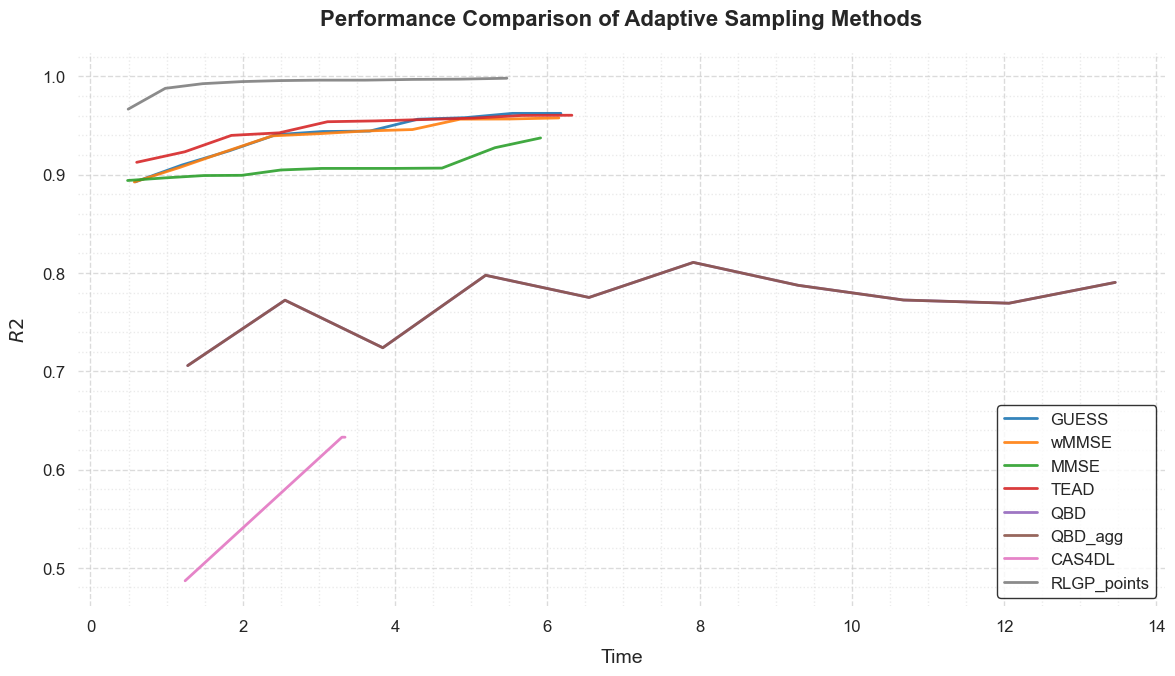

In [117]:
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.2)
fig, ax = plt.subplots(figsize=(12, 7))


for i, method in enumerate(methods):
    ax.plot(np.cumsum(Time[method]), R2[method],
            label=method, 
            linewidth=2.,
            alpha=0.9)

ax.set_title('Performance Comparison of Adaptive Sampling Methods', 
             pad=20, fontsize=16, fontweight='bold')
ax.set_xlabel('Time', labelpad=10, fontsize=14)
ax.set_ylabel('$R2$', labelpad=10, fontsize=14)
legend = ax.legend(loc='lower right',  
                    fontsize=12)
legend.get_frame().set_edgecolor('black')
ax.grid(True, linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which='minor', linestyle=':', alpha=0.4)
ax.minorticks_on()
plt.tight_layout()
plt.savefig('method_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

In [167]:
mse['RLGP_points+prediction'] = 2.868582983213736
inference_time['RLGP_points+prediction'] = 0.030337095260620117

mse['RLNN_points+prediction'] = 2.3524111236190683
inference_time['RLNN_points+prediction'] = 0.0018699169158935547

mse['RLGP_points'] = 0.6710723765436305
inference_time['RLGP_points'] = 0.06399798393249512

mse['RLNN_points'] = 0.41093378806423037
inference_time['RLNN_points'] = 0.0004551410675048828

In [169]:
 mse.keys()

dict_keys(['GP GUESS', 'GP wMMSE', 'GP MMSE', 'GP TEAD', 'QBC', 'QBC_aggr', 'CAS4DL', 'RLGP_points+prediction', 'RLNN_points+prediction', 'RLGP_points', 'RLNN_points'])

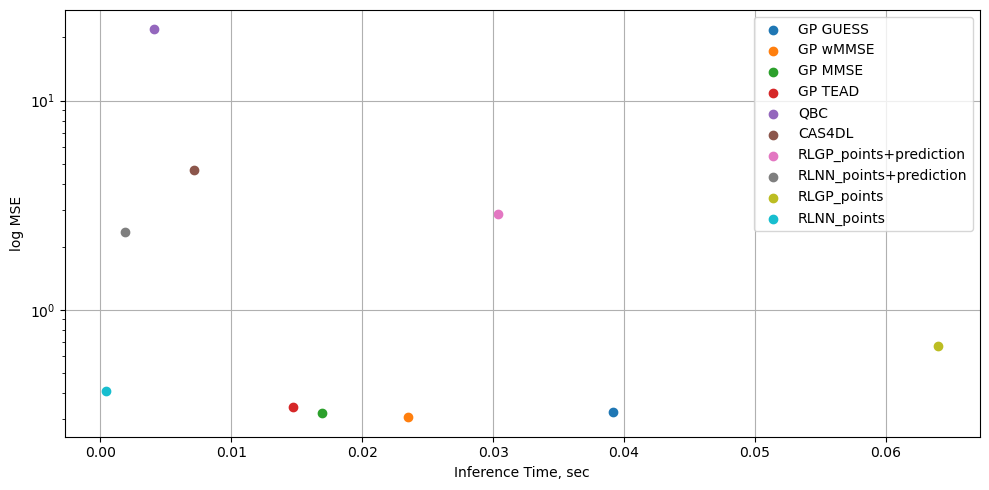

In [171]:
name =['GP GUESS', 'GP wMMSE', 'GP MMSE', 'GP TEAD', 'QBC', 'CAS4DL', 'RLGP_points+prediction', 'RLNN_points+prediction', 'RLGP_points', 'RLNN_points']
fig, ax = plt.subplots(figsize=(10, 5))
i = 0
for col in name:
    ax.scatter(inference_time[col],mse[col], label=col)
    i+=1
    
ax.set_ylabel("log MSE")
ax.set_xlabel("Inference Time, sec")
ax.set_yscale('log')
plt.legend()
plt.tight_layout()

plt.grid()
plt.show()  

In [76]:
from importlib import reload 
import bench_functions
bench_functions = reload(bench_functions)
from bench_functions import OneDFunctions

<Axes: title={'center': 'Ackley Function'}, xlabel='x', ylabel='f(x)'>

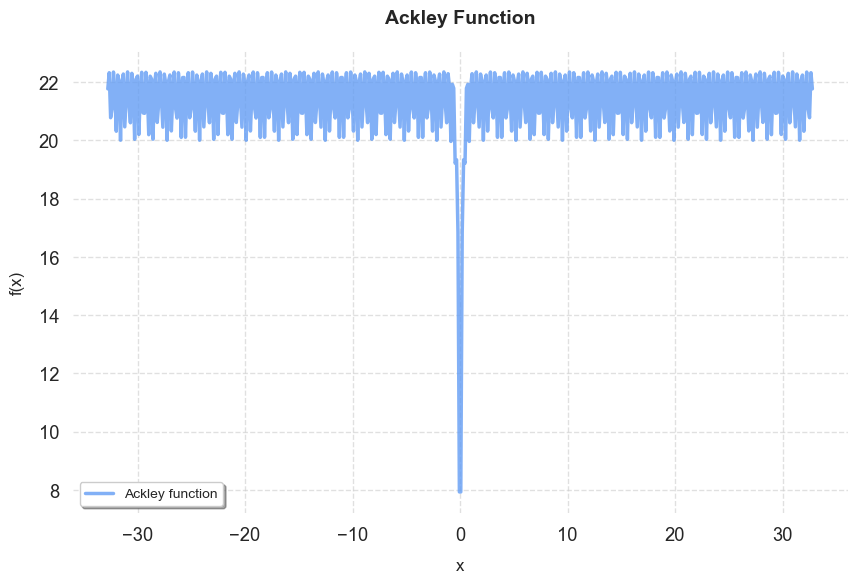

In [101]:
func.plot_function('Ackley')

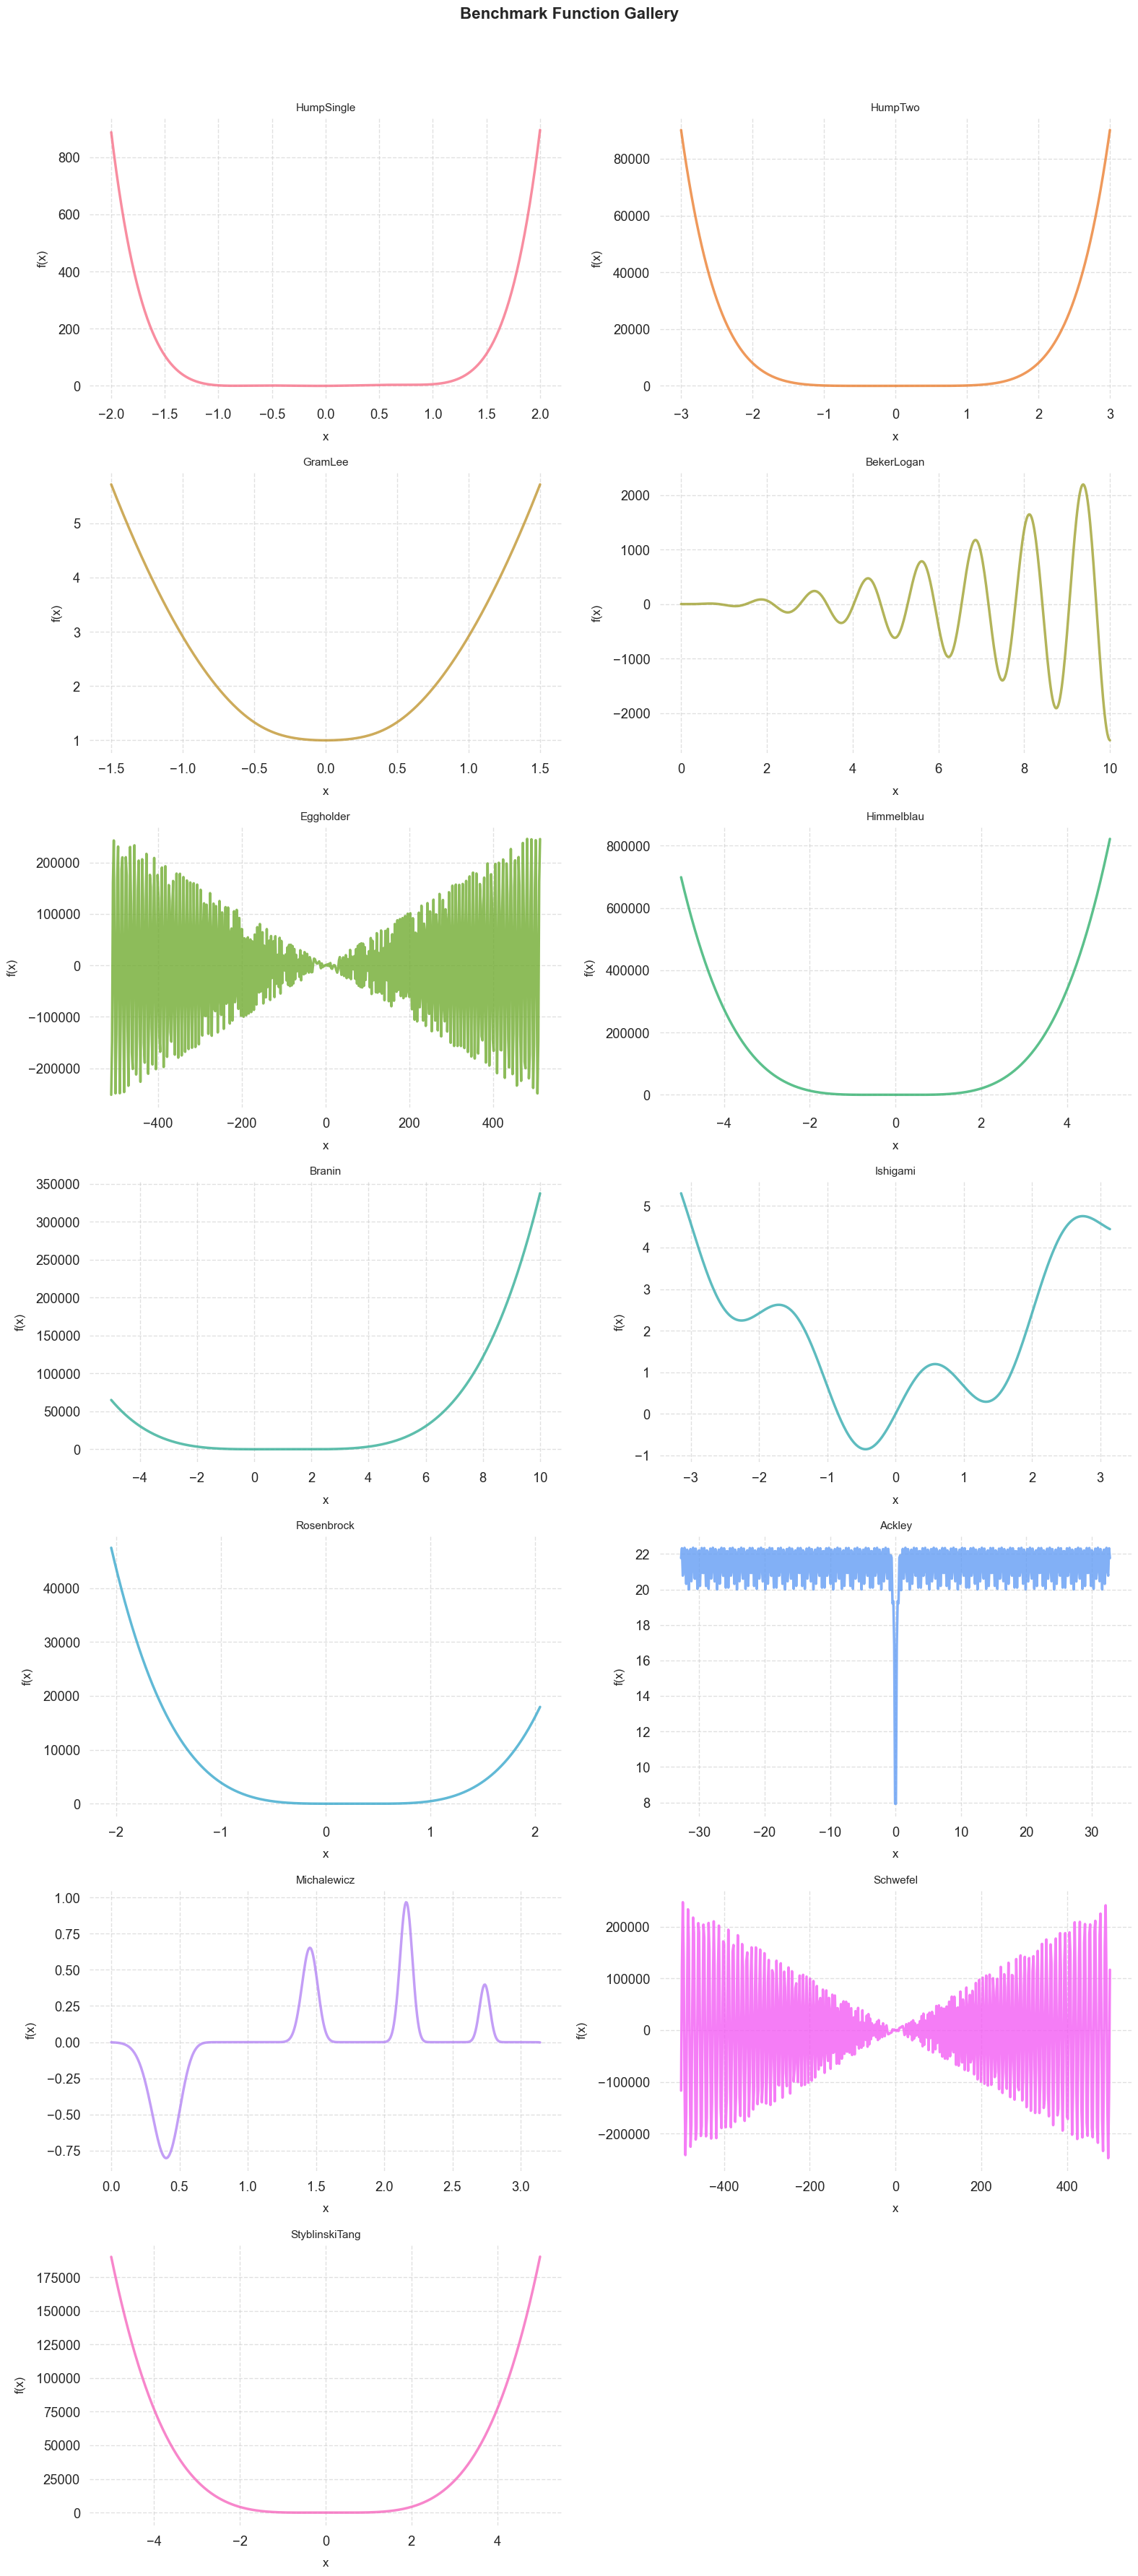

In [99]:
a = func.plot_all_functions(n_cols=2)